# Phase 3: Aleatoire

In this phase we introduce random and chaos into the simulations. We use the model established in Phase 2, all of the useful functions are in `model.py`. 

In [ ]:
from model import *

The goal of this phase is to make the model more realistic by making the parameters random for the drivers, with a certain standard deviation that we are going to vary to analyze the sensitivity of the model. 

The parameters we are going to target are: 

- `V_target`: Not everyone respects the speed limit. For some a few km/h is not that serious so they want to go faster, still having higher target speed in mind. Some prefer going lower than the limit for precaution. We are going to sample from a normal distribution.
- `TTC`: Different drivers keep different distances, as they have a different TTC they are using. We will model this with a normal with mean 2.0(s).
- `k`: This is the factor of 'agressive drivers'. It is a coefficient between 0 and 1, on how much will the driver want to accelerate instantly(basically how quickly the driver reacts to opportunities). We will sample from a normal with mean 0.5
- `T_reac`: This is for encorporating the lag between perception and action and the car lag(the time it takes after u pressed the pedal for the car to accelerate or decelerate). We will model this with a normal with mean 0.5


In [12]:
default_params = create_params()

## Interactive Simulation

In [13]:
brake_moments = [10., 60., 130.]

# last simulation parameters
last_sim_params = None
last_sim_data = None

def interact(V_target_sigma, t_reac_sigma, ttc_sigma, brake_force, brake_time, t):
    global last_sim_params, last_sim_data
    
    V_target_sample = np.maximum(np.random.normal(default_params['V_target'], V_target_sigma, default_params['N']), 0.01)
    ttc = np.maximum(np.random.normal(default_params['ttc'], ttc_sigma, default_params['N']), 0.01)
    t_reac = np.maximum(np.random.normal(default_params['t_reac'], t_reac_sigma, default_params['N']), 0.01)
    
    params = create_params(V_target=V_target_sample, t_reac=t_reac, ttc=ttc)

    current_params = (
        V_target_sigma,
        ttc_sigma,
        t_reac_sigma,
        brake_force,
        brake_time,
    )

    if last_sim_params != current_params:
        last_sim_data = get_simulation_data(params, (brake_force, brake_time), brake_moments)
        last_sim_params = current_params
    
    visualize(last_sim_data, params, brake_moments, t)


In [ ]:
import ipywidgets as widgets
style = {'description_width': 'initial'}
layout = widgets.Layout(width='90%')
ui = widgets.interactive(
    interact,
    V_target_sigma=widgets.FloatSlider(min=0.0, max=10.0, step=0.1, value=0.1, description='V_max Sigma', style=style, layout=layout),
    t_reac_sigma=widgets.FloatSlider(min=0.01, max=1.0, step=0.01, value=0.1, description='t_reac Sigma', style=style, layout=layout),
    ttc_sigma=widgets.FloatSlider(min=0.05, max=1.0, step=0.05, value=0.1, description='TTC Sigma', style=style, layout=layout),
    
    brake_force=widgets.FloatSlider(min=1.0, max=a_max_ref, step=1.0, value=5.0, description='Brake Force', style=style, layout=layout),
    brake_time=widgets.FloatSlider(min=1.0, max=50.0, step=0.5, value=5.0, description='Brake Duration', style=style, layout=layout),
    t=widgets.FloatSlider(min=0.0, max=T_total, step=0.5, value=0.0, description='Time', style=style, layout=layout)
)

# Export Button
btn_export = widgets.Button(description="Export Animation", icon="download")
out_export = widgets.Output()

def on_export_click(b):
    with out_export:
        out_export.clear_output()
        print("Generating animation... please wait.")
        
        k = ui.kwargs
        V_target_sample = np.maximum(np.random.normal(default_params['V_target'], k['V_target_sigma'], default_params['N']), 0.01)
        ttc = np.random.normal(default_params['ttc'], k['ttc_sigma'], default_params['N'])
        ttc = np.maximum(ttc, 0.01)
        t_reac = np.random.normal(default_params['t_reac'], k['t_reac_sigma'], default_params['N'])
        t_reac = np.maximum(t_reac, 0.01)
        p = create_params(V_target=V_target_sample, t_reac=t_reac, ttc=ttc)
        brake = (k['brake_force'], k['brake_time'])
    
        try:
            anim = animate(p, brake, brake_moments)
            filename = (
                f"traffic_V_sigma{k['V_target_sigma']}_tr_sigma{k['t_reac_sigma']}_ttc_sigma{k['ttc_sigma']}"
                f"_bf{brake[0]}_bd{brake[1]}.mp4"
            )
            writer = animation.FFMpegWriter(fps=15, bitrate=2000)
            anim.save(filename, writer=writer)
            print(f"Done! Saved to {filename}")
        except NameError:
            print("Error: Please run the cell below to define 'animate' first.")

btn_export.on_click(on_export_click)

display(ui, btn_export, out_export)

interactive(children=(FloatSlider(value=0.1, description='V_max Sigma', layout=Layout(width='90%'), max=10.0, …

Button(description='Export Animation', icon='download', style=ButtonStyle())

Output()

## Independent variance analysis

We vary one of the distributions for the parameters(by changing the std), and keep all of the others fixed

In [5]:
import tqdm


ttc_sigma = np.linspace(0.0, 1.0, 30)
k_sigma = np.linspace(0.0, 0.45, 30)
t_reac_sigma = np.linspace(0.0, 0.45, 30)
v_target_sigma = np.linspace(0.0, 10.0, 30)

TRIALS = 100                            

results = {
    'ttc': {
        'sigmas': ttc_sigma,
        'crash_rate': [],
        'speed_std':[],
        'speed_mean':[],
        'gap_std':[],
        'gap_mean':[],
        'gap_min':[]
    },
    'k': {
        'sigmas': k_sigma,
        'crash_rate': [],
        'speed_std':[],
        'speed_mean':[],
        'gap_std':[],
        'gap_mean':[],
        'gap_min':[]
    },
    'V_target': {
        'sigmas': v_target_sigma,
        'crash_rate': [],
        'speed_std':[],
        'speed_mean':[],
        'gap_std':[],
        'gap_mean':[],
        'gap_min':[]
    },
    't_reac': {
        'sigmas': t_reac_sigma,
        'crash_rate': [],
        'speed_std':[],
        'speed_mean':[],
        'gap_std':[],
        'gap_mean':[],
        'gap_min':[]
    }
}


for sigma in tqdm.tqdm(ttc_sigma):
    crashes = 0
    
    speed_s = 0.
    speed_m = 0.
    gap_s  = 0.
    gap_m = 0.
    gap_mn = 0.
    for _ in range(TRIALS):
        ttc = np.maximum(np.random.normal(default_params['ttc'], sigma, default_params['N']), 0.01)
        s_std, s_mean, g_std, g_mean, g_min, is_crash = simulate(create_params(ttc=ttc),[(10., 5., 3.)], metrics=True)
        
        speed_s+=s_std
        speed_m+=s_mean
        gap_s+=g_std
        gap_m+=g_mean
        gap_mn+=g_min
        if is_crash: crashes += 1
        
    results['ttc']['crash_rate'].append(crashes / TRIALS)
    results['ttc']['speed_std'].append(speed_s/TRIALS)
    results['ttc']['speed_mean'].append(speed_m/TRIALS)
    results['ttc']['gap_std'].append(gap_s/TRIALS)
    results['ttc']['gap_mean'].append(gap_m/TRIALS)
    results['ttc']['gap_min'].append(gap_mn/TRIALS)

for sigma in tqdm.tqdm(k_sigma):
    crashes = 0
    speed_s = 0.
    speed_m = 0.
    gap_s  = 0.
    gap_m = 0.
    gap_mn = 0.
    for _ in range(TRIALS):
        k_val = np.clip(np.random.normal(0.6, sigma, default_params['N']), 0.01, 1.0)
        s_std, s_mean, g_std, g_mean, g_min, is_crash = simulate(create_params(k=k_val),[(10., 5., 3.)], metrics=True)
        
        speed_s+=s_std
        speed_m+=s_mean
        gap_s+=g_std
        gap_m+=g_mean
        gap_mn+=g_min
        if is_crash: crashes += 1
        
    results['k']['crash_rate'].append(crashes / TRIALS)
    results['k']['speed_std'].append(speed_s/TRIALS)
    results['k']['speed_mean'].append(speed_m/TRIALS)
    results['k']['gap_std'].append(gap_s/TRIALS)
    results['k']['gap_mean'].append(gap_m/TRIALS)
    results['k']['gap_min'].append(gap_mn/TRIALS)

for sigma in tqdm.tqdm(v_target_sigma):
    crashes = 0
    speed_s = 0.
    speed_m = 0.
    gap_s  = 0.
    gap_m = 0.
    gap_mn = 0.
    for _ in range(TRIALS):
        v_t = np.maximum(np.random.normal(30.0, sigma, default_params['N']), 0.01)
        s_std, s_mean, g_std, g_mean, g_min, is_crash = simulate(create_params(V_target=v_t),[(10., 5., 3.)], metrics=True)
        
        speed_s+=s_std
        speed_m+=s_mean
        gap_s+=g_std
        gap_m+=g_mean
        gap_mn+=g_min
        if is_crash: crashes += 1
        
    results['V_target']['crash_rate'].append(crashes / TRIALS)
    results['V_target']['speed_std'].append(speed_s/TRIALS)
    results['V_target']['speed_mean'].append(speed_m/TRIALS)
    results['V_target']['gap_std'].append(gap_s/TRIALS)
    results['V_target']['gap_mean'].append(gap_m/TRIALS)
    results['V_target']['gap_min'].append(gap_mn/TRIALS)

for sigma in tqdm.tqdm(t_reac_sigma):
    crashes = 0
    speed_s = 0.
    speed_m = 0.
    gap_s  = 0.
    gap_m = 0.
    gap_mn = 0.
    for _ in range(TRIALS):
        t_r = np.maximum(np.random.normal(0.5, sigma, default_params['N']), 0.01)
        s_std, s_mean, g_std, g_mean, g_min, is_crash = simulate(create_params(t_reac=t_r),[(10., 5., 3.)], metrics=True)
        
        speed_s+=s_std
        speed_m+=s_mean
        gap_s+=g_std
        gap_m+=g_mean
        gap_mn+=g_min
        if is_crash: crashes += 1
        
    results['t_reac']['crash_rate'].append(crashes / TRIALS)
    results['t_reac']['speed_std'].append(speed_s/TRIALS)
    results['t_reac']['speed_mean'].append(speed_m/TRIALS)
    results['t_reac']['gap_std'].append(gap_s/TRIALS)
    results['t_reac']['gap_mean'].append(gap_m/TRIALS)
    results['t_reac']['gap_min'].append(gap_mn/TRIALS)
    
np.save('simulation_data.npy', results)
print("Simulation Complete. Data saved.")

 43%|████▎     | 13/30 [01:41<02:04,  7.35s/it]/run/media/sipanb/Data/University/S5/modelisation/projet/final/refactored/model.py:121: RuntimeWarning: overflow encountered in multiply
  A[i+1] = A[i] + (dt / params['t_reac']) * (u - A[i])
/run/media/sipanb/Data/University/S5/modelisation/projet/final/refactored/model.py:121: RuntimeWarning: invalid value encountered in add
  A[i+1] = A[i] + (dt / params['t_reac']) * (u - A[i])
100%|██████████| 30/30 [01:59<00:00,  3.97s/it]

Simulation Complete. Data saved.


We plot the probability of a crash for each std tested, the mean speed of the vehicles at the end of simulations(if a crash is detected, the simulation is stopped, so at the moment of the crash in that case), with the std of speeds in the same plot. Same with the gaps.  

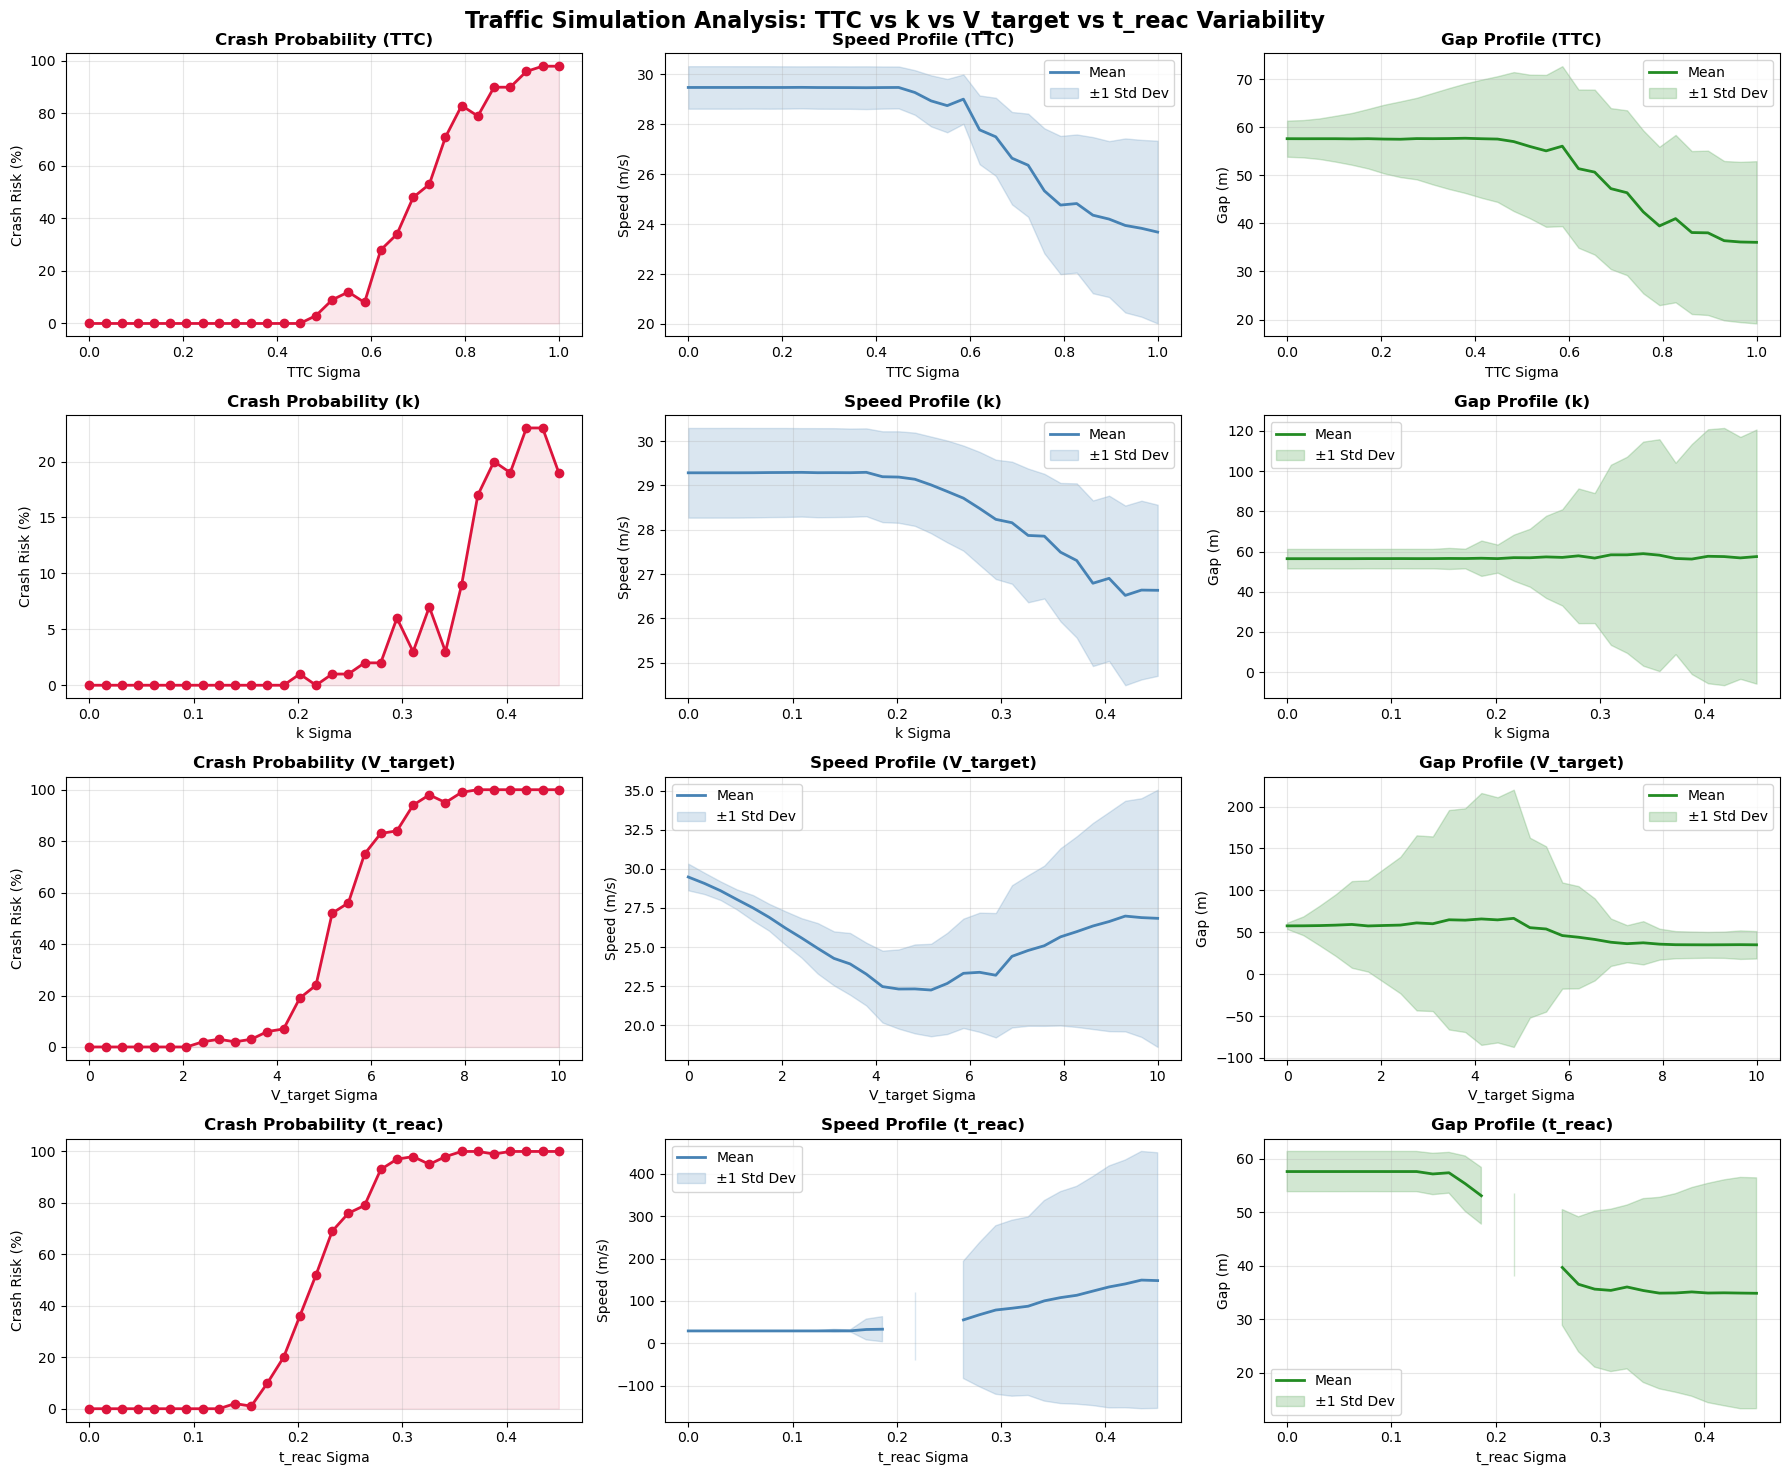

In [7]:
res = np.load('simulation_data.npy', allow_pickle=True).item()
ttc = res['ttc']
k_res = res['k']
v_target = res['V_target']
t_reac = res['t_reac']

sigmas_ttc = ttc['sigmas']
sigmas_k = k_res['sigmas']
sigmas_v = v_target['sigmas']
sigmas_t_reac = t_reac['sigmas']

fig, axes = plt.subplots(4, 3, figsize=(18, 15))
fig.suptitle('Traffic Simulation Analysis: TTC vs k vs V_target vs t_reac Variability', fontsize=16, fontweight='bold')

def plot_metric_with_std(ax, x, mean, std, color='blue', title="", xlabel="", ylabel=""):
    mean = np.array(mean)
    std = np.array(std)
    
    # Plot Mean
    ax.plot(x, mean, '-', color=color, lw=2, label='Mean')
    
    ax.fill_between(x, mean - std, mean + std, color=color, alpha=0.2, label='±1 Std Dev')
        
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    ax.legend()

def plot_crash_probability(ax, x, crash_rate, color='crimson', title="", xlabel="", ylabel="Crash Risk (%)"):
    ax.plot(x, np.array(crash_rate)*100, 'o-', color=color, lw=2)
    ax.fill_between(x, 0, np.array(crash_rate)*100, color=color, alpha=0.1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontweight='bold')
    ax.grid(True, alpha=0.3)

def plot_parameter_stats(ax_row, sigmas, data, param_name):
    xlabel = f"{param_name} Sigma"
    
    # Crash Probability
    plot_crash_probability(ax_row[0], sigmas, data['crash_rate'], 
                          title=f"Crash Probability ({param_name})", xlabel=xlabel)
    # Speed Profile
    plot_metric_with_std(ax_row[1], sigmas, data['speed_mean'], data['speed_std'], 
                         color='steelblue', title=f"Speed Profile ({param_name})", xlabel=xlabel, ylabel="Speed (m/s)")
    # Gap Profile
    plot_metric_with_std(ax_row[2], sigmas, data['gap_mean'], data['gap_std'],
                         color='forestgreen', title=f"Gap Profile ({param_name})", xlabel=xlabel, ylabel="Gap (m)")

### ttc
plot_parameter_stats(axes[0], sigmas_ttc, ttc, "TTC")

### k
plot_parameter_stats(axes[1], sigmas_k, k_res, "k")

### v_target
plot_parameter_stats(axes[2], sigmas_v, v_target, "V_target")

### t_reac
plot_parameter_stats(axes[3], sigmas_t_reac, t_reac, "t_reac")

plt.tight_layout()
plt.savefig('simulation_analysis.png')

## Covariate Analysis

In this part we pair parameters together, and vary them together. We create heatmaps to analyze the covariant behavior of the model.

In [9]:
N_GRID = 15
TRIALS_HEATMAP = 50

ttc_sigmas_hm = np.linspace(0.0, 1.0, N_GRID)
v_target_sigmas_hm = np.linspace(0.0, 10.0, N_GRID)
t_reac_sigmas_hm = np.linspace(0.0, 0.45, N_GRID)
k_sigmas_hm = np.linspace(0.0, 0.45, N_GRID)

def get_param_values(name, sigma, N):
    if name == 'ttc':
        return np.maximum(np.random.normal(default_params['ttc'], sigma, N), 0.01)
    elif name == 'k':
        return np.clip(np.random.normal(0.6, sigma, N), 0.01, 1.0)
    elif name == 'V_target':
        return np.maximum(np.random.normal(30.0, sigma, N), 0.01)
    elif name == 't_reac':
        return np.maximum(np.random.normal(default_params['t_reac'], sigma, N), 0.01)

def compute_heatmap(x_name, x_range, y_name, y_range):
    hm = np.zeros((len(y_range), len(x_range)))
    print(f"Computing {y_name} vs {x_name}...")
    for i, y_s in enumerate(tqdm.tqdm(y_range)):
        for j, x_s in enumerate(x_range):
            crashes = 0
            for _ in range(TRIALS_HEATMAP):
                kwargs = {}
                kwargs[x_name] = get_param_values(x_name, x_s, default_params['N'])
                kwargs[y_name] = get_param_values(y_name, y_s, default_params['N'])
                
                _, _, _, _, _, is_crash = simulate(create_params(**kwargs), [(10., 5., 3.)], metrics=True)
                if is_crash: crashes += 1
            hm[i, j] = crashes / TRIALS_HEATMAP
    return hm

heatmaps = {}
heatmaps['v_ttc'] = compute_heatmap('ttc', ttc_sigmas_hm, 'V_target', v_target_sigmas_hm)
heatmaps['tr_ttc'] = compute_heatmap('ttc', ttc_sigmas_hm, 't_reac', t_reac_sigmas_hm)
heatmaps['v_tr'] = compute_heatmap('t_reac', t_reac_sigmas_hm, 'V_target', v_target_sigmas_hm)
heatmaps['ttc_k'] = compute_heatmap('k', k_sigmas_hm, 'ttc', ttc_sigmas_hm)

np.save('covariate_heatmaps_data.npy', {
    'heatmaps': heatmaps,
    'ranges': {
        'ttc': ttc_sigmas_hm,
        'V_target': v_target_sigmas_hm,
        't_reac': t_reac_sigmas_hm,
        'k': k_sigmas_hm
    }
})

Computing V_target vs ttc...


100%|██████████| 15/15 [04:47<00:00, 19.19s/it]


Computing t_reac vs ttc...


 27%|██▋       | 4/15 [02:42<07:24, 40.39s/it]/run/media/sipanb/Data/University/S5/modelisation/projet/final/refactored/model.py:121: RuntimeWarning: overflow encountered in multiply
  A[i+1] = A[i] + (dt / params['t_reac']) * (u - A[i])
/run/media/sipanb/Data/University/S5/modelisation/projet/final/refactored/model.py:121: RuntimeWarning: invalid value encountered in add
  A[i+1] = A[i] + (dt / params['t_reac']) * (u - A[i])
/run/media/sipanb/Data/University/S5/modelisation/projet/final/refactored/model.py:121: RuntimeWarning: overflow encountered in multiply
  A[i+1] = A[i] + (dt / params['t_reac']) * (u - A[i])
/run/media/sipanb/Data/University/S5/modelisation/projet/final/refactored/model.py:121: RuntimeWarning: invalid value encountered in add
  A[i+1] = A[i] + (dt / params['t_reac']) * (u - A[i])
 40%|████      | 6/15 [03:58<05:50, 38.94s/it]/home/sipanb/.local/share/mamba/envs/modelisation/lib/python3.12/site-packages/numpy/_core/_methods.py:193: RuntimeWarning: overflow encount

Computing V_target vs t_reac...


100%|██████████| 15/15 [04:05<00:00, 16.34s/it]


Computing ttc vs k...


100%|██████████| 15/15 [09:03<00:00, 36.24s/it]


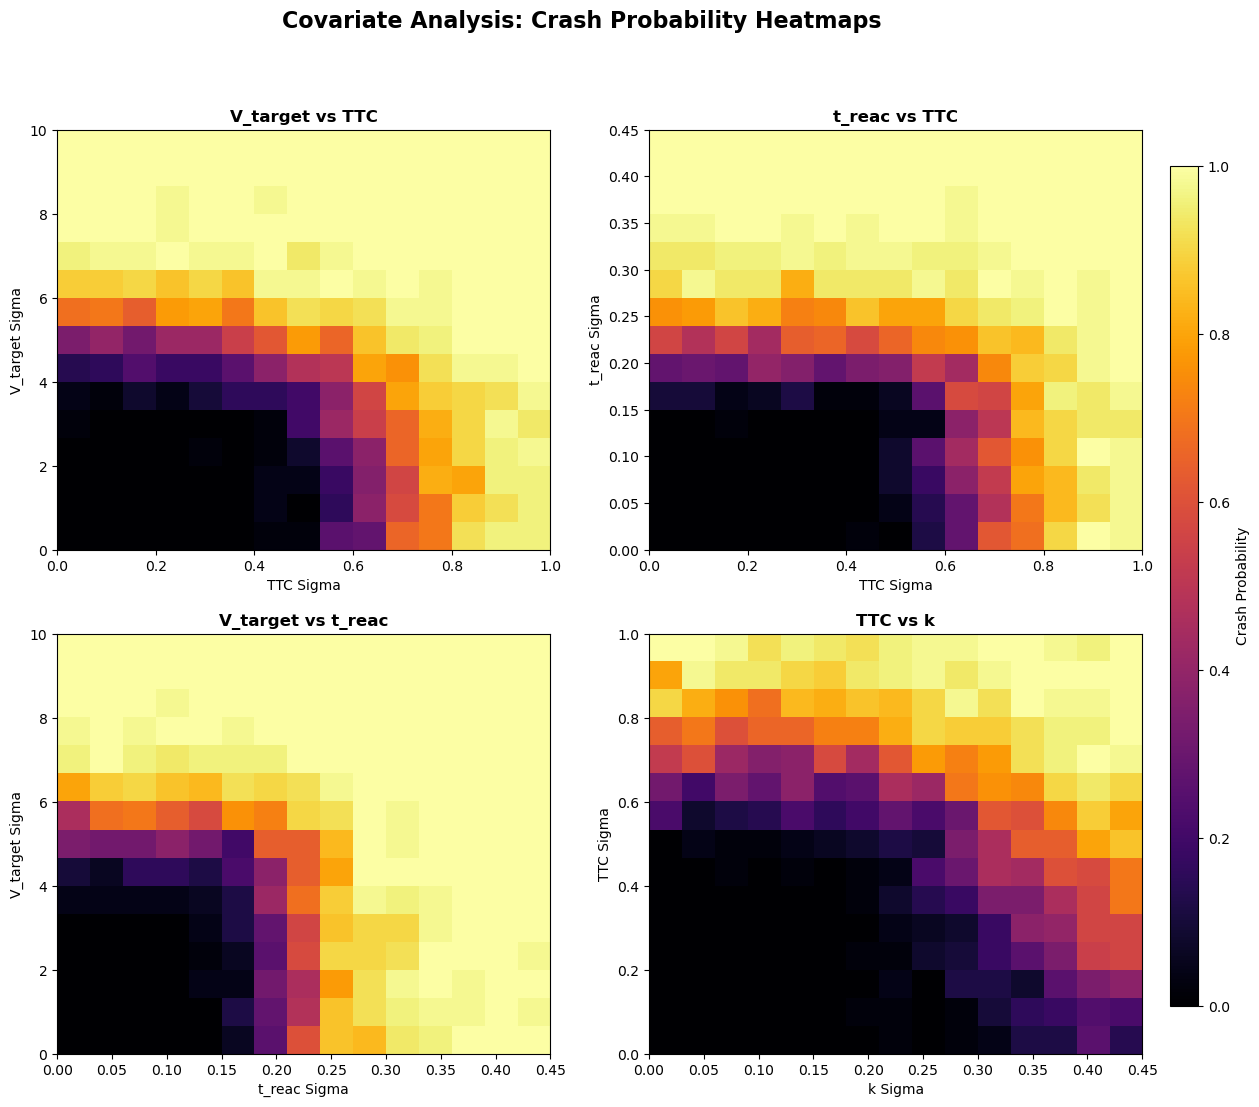

In [11]:
heatmaps_data = np.load('covariate_heatmaps_data.npy', allow_pickle=True).item()
heatmaps = heatmaps_data['heatmaps']
ranges = heatmaps_data['ranges']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Covariate Analysis: Crash Probability Heatmaps', fontsize=16, fontweight='bold')

def plot_heatmap(ax, data, x_range, y_range, xlabel, ylabel, title):
    im = ax.imshow(data, origin='lower', aspect='auto', cmap='inferno', 
                   extent=[x_range[0], x_range[-1], y_range[0], y_range[-1]], vmin=0, vmax=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontweight='bold')
    return im

# 1. V_target vs TTC
im1 = plot_heatmap(axes[0,0], heatmaps['v_ttc'], ranges['ttc'], ranges['V_target'], 
             'TTC Sigma', 'V_target Sigma', 'V_target vs TTC')

# 2. t_reac vs TTC
im2 = plot_heatmap(axes[0,1], heatmaps['tr_ttc'], ranges['ttc'], ranges['t_reac'], 
             'TTC Sigma', 't_reac Sigma', 't_reac vs TTC')

# 3. V_target vs t_reac
im3 = plot_heatmap(axes[1,0], heatmaps['v_tr'], ranges['t_reac'], ranges['V_target'], 
             't_reac Sigma', 'V_target Sigma', 'V_target vs t_reac')

# 4. TTC vs k
im4 = plot_heatmap(axes[1,1], heatmaps['ttc_k'], ranges['k'], ranges['ttc'], 
             'k Sigma', 'TTC Sigma', 'TTC vs k')

# Add a common colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label='Crash Probability')

plt.subplots_adjust(right=0.9)
plt.savefig('covariate_heatmaps.png')
plt.show()